# learning to iterate with pytorch

In [324]:
import torch
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
print(torch.cuda.get_device_name(0))

print('cuda', torch.cuda.is_available())

# https://cs230-stanford.github.io/pytorch-getting-started.html#using-the-gpu

GeForce RTX 2070
cuda True


In [299]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

print(device)

cuda:0


In [449]:
%matplotlib inline
from pandas_datareader import data as pdr
import datetime
import fix_yahoo_finance as yf
from ratelimit import limits, sleep_and_retry
import sklearn.preprocessing as skp
from joblib import Memory
import os
from pylab import *
_mydir = '.'

cachedir = os.path.join(_mydir, 'joblib_cache')
memory = Memory(cachedir, verbose=1)

yf.pdr_override()
_period_seconds = 1
@memory.cache
@sleep_and_retry
@limits(calls=1, period=_period_seconds)
def _get_data_yahoo(names, start, end):
    return pdr.get_data_yahoo(names, start=start, end=end)

def get_data_yahoo(names, start, end):
    df = _get_data_yahoo(names, start, end)
    if len(names) > 1:
        df = df.stack()
        df.index.names = ['date', 'name']
    else:
        df['name'] = names[0]
    df = df.reset_index()
    df.columns = [x.lower().replace(' ', '_') for x in df.columns]
    return df


names = ['soxx', 'spy', 'aapl', 'noc', 'gs']
start = datetime.date(2010, 1, 1)
end = datetime.date(2018, 11, 1)

data = get_data_yahoo(names, start, end)
data = data.sort_values(by='date')
data.shape

dates = data.date.unique()
dates.sort()
test_frac = 0.2
date_test = dates[int(len(dates) * (1 - test_frac))]
def split_data_by_date(data, date):
    i = data.date < date
    data_train = data[i]
    data_test = data[~i]
    print(data_train.shape, data_test.shape)
    return data_train, data_test

# one now for now
name = 'NOC'
data_train, data_test = split_data_by_date(data[data.name == name], date_test)

# do NO transformations for now, will be weird
xcols = ['adj_close', 'close', 'high', 'low', 'open', 'volume']
ycols = ['adj_close'] # shifted obviosly
pcols = ['adj_close', 'close', 'high', 'low', 'open']
output_dim = len(ycols)

def lagger(df, periods=[1]):
    d = list()
    for x in periods:
        temp = df.shift(periods=x)
        temp.columns = ['{}_lag{}'.format(k, x) for k in temp.columns] 
        d.append(temp)
    return pd.concat(d, axis=1)

d = lagger(data[xcols], periods=[1, 2, 3, 5, 10])

def getxy(data):
    assert data.name.nunique() == 1, 'you need to change the code if you do this'
    # watch out for overflow etc, TODO norm
    data = data.copy()
    data[pcols] = np.log(data[pcols]).diff()
    data = data.iloc[1:]
    
    t = skp.QuantileTransformer(output_distribution='normal')
    t.fit(data[pcols])
    data[pcols] = t.transform(data[pcols])
    
    lags = [1, 2, 3, 5, 10]
    X = lagger(data[xcols], lags)
    X = pd.concat([data[xcols], X], axis=1).values

    predict_steps = 1
    y = data.shift(periods=-predict_steps)[ycols].values
    
    X = X[max(lags):-predict_steps]
    y = y[max(lags):-predict_steps]
    
    # add some lag features
    assert not np.any(np.isnan(X))
    assert not np.any(np.isnan(y))
    return X, y

X_train, y_train = getxy(data_train)
X_test, y_test = getxy(data_test)
X_train.shape, y_train.shape

input_dim = X_train.shape[1]

(1779, 8) (445, 8)


In [447]:
data.head()

,date,name,adj_close,close,high,low,open,volume
0,2010-01-04,AAPL,20.473503,30.572857,30.642857,30.340000,30.490000,123432400
1,2010-01-04,GS,153.768127,173.080002,174.250000,169.509995,170.050003,9135000
2,2010-01-04,NOC,41.341614,51.363976,51.382046,50.686352,50.686352,1616100
3,2010-01-04,SOXX,45.102173,49.830002,50.270000,49.660000,49.790001,126800
4,2010-01-04,SPY,95.097603,113.330002,113.389999,111.510002,112.370003,118944600


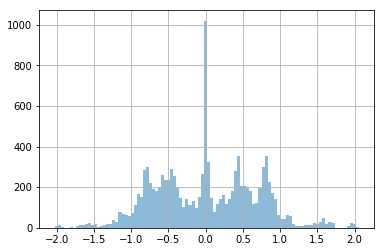

In [451]:
_ = np.log(data.adj_close).diff().dropna().hist(bins=100, alpha=0.5)

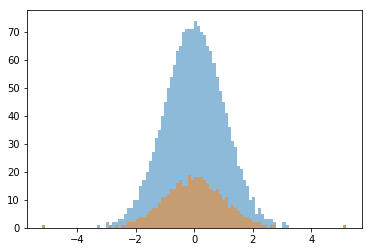

In [450]:
%matplotlib inline
_ = hist(y_train, bins=100, alpha=0.5)
_ = hist(y_test, bins=100, alpha=0.5)


In [442]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
try:
    counter
except NameError as e:
    counter = -1
counter += 1
writer = SummaryWriter(comment='-{}-playground'.format(counter))

class Module(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob=0.1):
        super().__init__()
        self.pipe = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(input_dim, 32),
            nn.ReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.Linear(8, 8),
#             nn.ReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.Linear(8, 8),
#             nn.ReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.Linear(8, 8),
#             nn.ReLU(),
#             nn.Dropout(p=dropout_prob),
            nn.Linear(32, output_dim)
#             nn.Linear(input_dim, output_dim)
        )
    def forward(self, x):
        return self.pipe(x)
    def predict(self, x):
        return self.pipe()
        
model = Module(input_dim, output_dim)
loss_function = nn.MSELoss()
# loss_function = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

writer.add_custom_scalars_multilinechart(['loss/train', 'loss/test'], title='losses')
torch.manual_seed(10)


gpu = True
if gpu:
    # model = model.to(device)
    model = model.cuda()
    # we have one small batch, all at once
    inputs = Variable(torch.from_numpy(X_train)).float().cuda()
    labels = Variable(torch.from_numpy(y_train)).float().cuda()

    inputs_test = Variable(torch.from_numpy(X_test)).float().cuda()
    labels_test = Variable(torch.from_numpy(y_test)).float().cuda()

In [443]:
0.999 ** 10000

4.517334597704824e-05

lr = 0.0001 epoch 1000, loss_train 60993.1953125, loss_test 4540.498046875


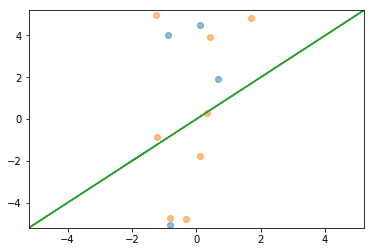

lr = 0.0001 epoch 2000, loss_train 427888.375, loss_test 97597.3359375


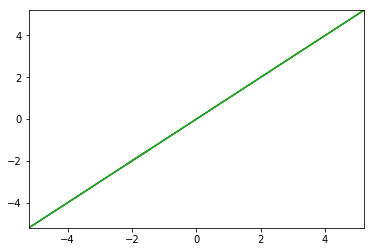

lr = 0.0001 epoch 3000, loss_train 5199.4208984375, loss_test 2381.6357421875


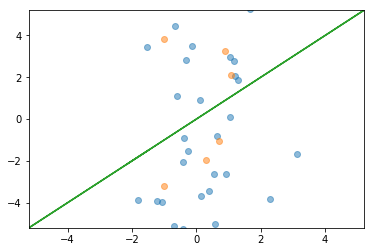

lr = 0.0001 epoch 4000, loss_train 16937.001953125, loss_test 545.384765625


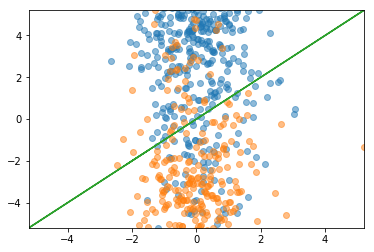

lr = 0.0001 epoch 5000, loss_train 9893.849609375, loss_test 20557.931640625


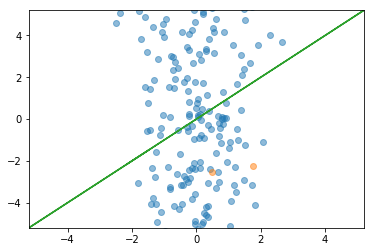

lr = 0.0001 epoch 6000, loss_train 34722.96875, loss_test 22995.541015625


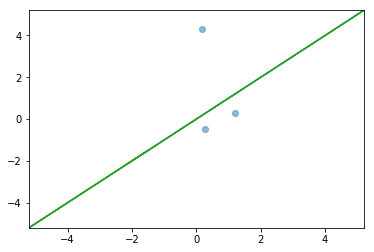

lr = 0.0001 epoch 7000, loss_train 1771.0595703125, loss_test 2020.384033203125


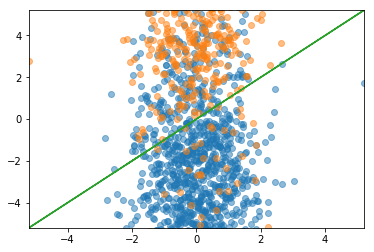

lr = 0.0001 epoch 8000, loss_train 24125.1484375, loss_test 3332.2021484375


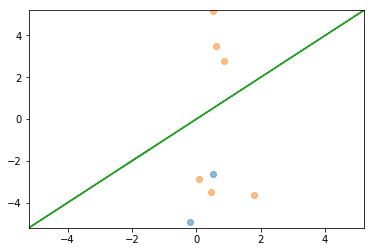

lr = 0.0001 epoch 9000, loss_train 6729.38037109375, loss_test 7500.47119140625


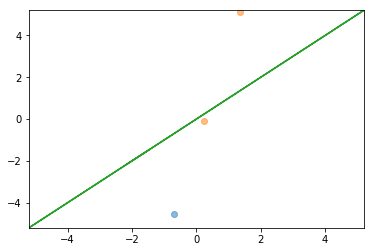

lr = 0.0001 epoch 10000, loss_train 159.8784942626953, loss_test 21.23398208618164


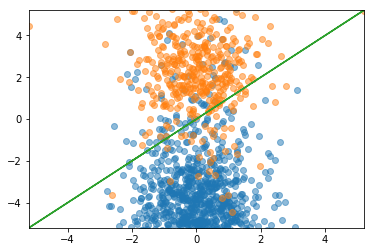

In [445]:
lr = 0.0001

epochs = 10000
epoch = 0
for epoch in range(epochs):
    epoch += 1

    optimizer.zero_grad()
    pred_train = model.forward(inputs)
    loss = loss_function(pred_train, labels)
    loss.backward()
    optimizer.step()
    
    pred_test = model.forward(inputs_test)
    loss_test = loss_function(pred_test, labels_test)
    
    writer.add_scalar('loss/train', loss.item(), epoch)
    writer.add_scalar('loss/test', loss_test.item(), epoch)
    
#     lr = lr * 0.9999

    if epoch % int(epochs/10) == 0:
        print('lr = {} epoch {}, loss_train {}, loss_test {}'.format(lr, epoch, loss.item(), loss_test.item()))
        figure()
        plot(y_train.squeeze(), pred_train.cpu().data.numpy().squeeze(), 'o', alpha=0.5)
        plot(y_test.squeeze(), pred_test.data.cpu().numpy().squeeze(), 'o', alpha=0.5)
        plot(y_train.squeeze(), y_train.squeeze())

        xlim(min(y_train), max(y_train))
        ylim(min(y_train), max(y_train))
        show()
        
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


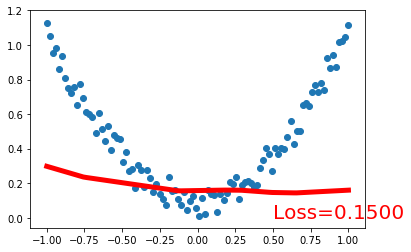

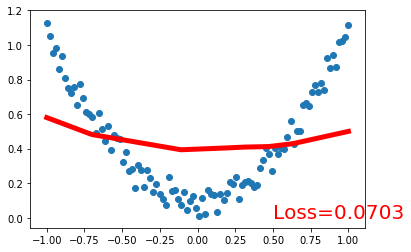

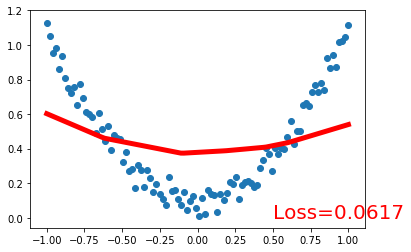

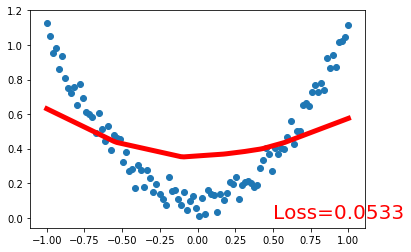

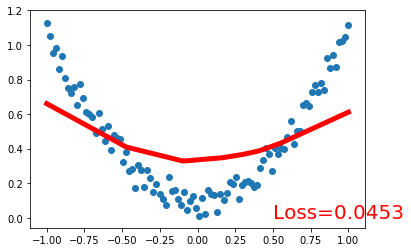

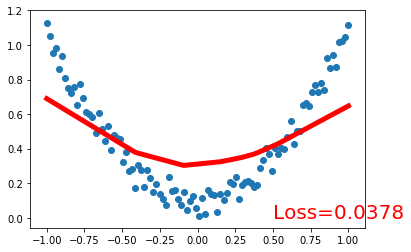

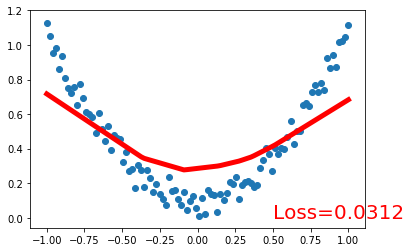

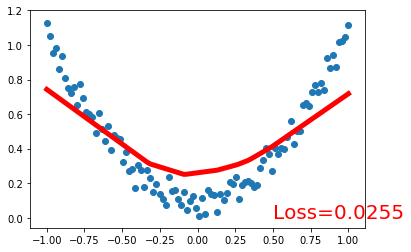

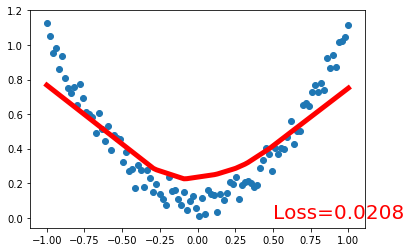

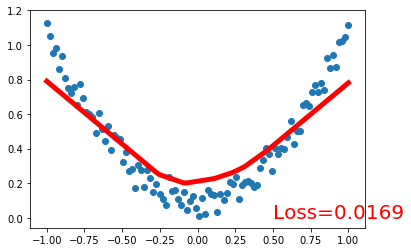

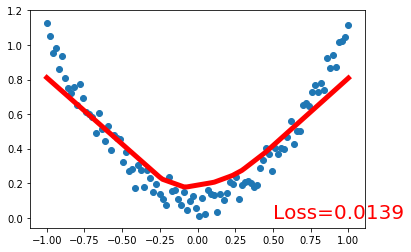

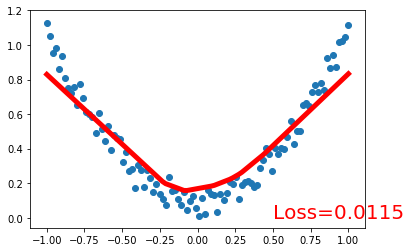

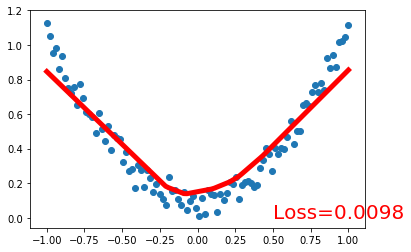

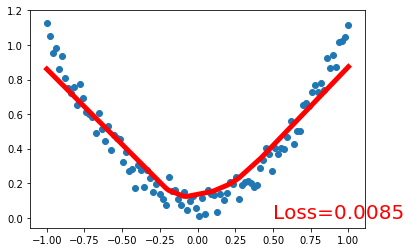

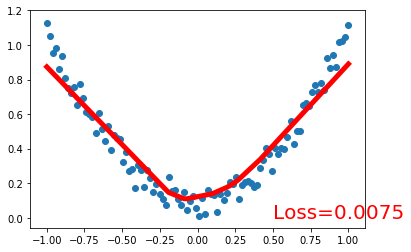

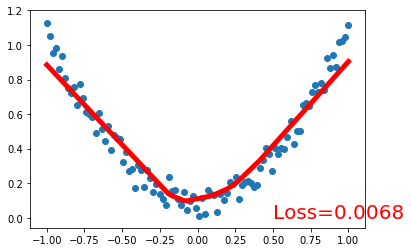

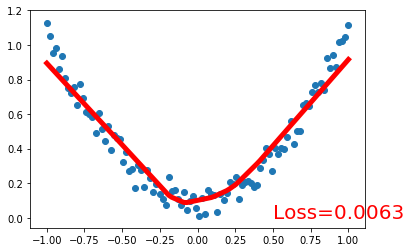

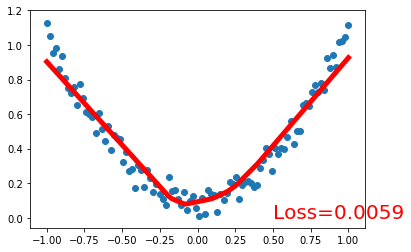

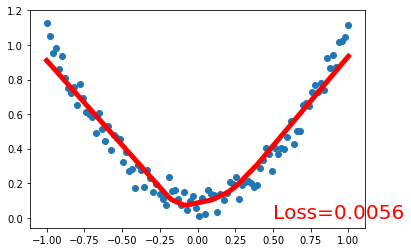

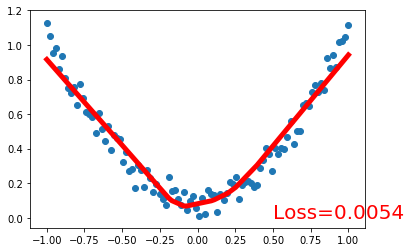

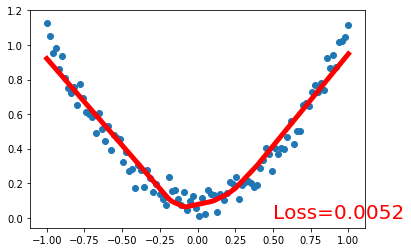

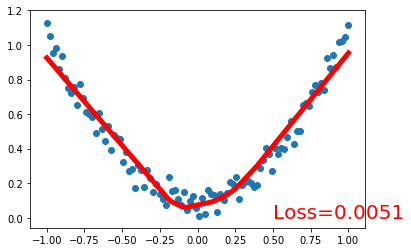

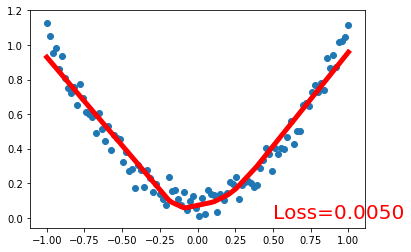

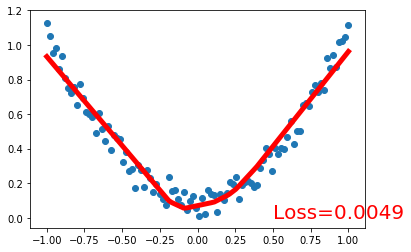

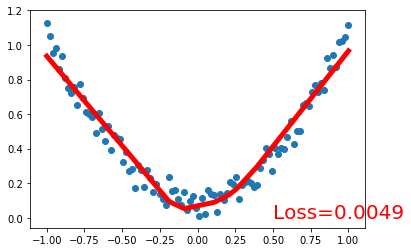

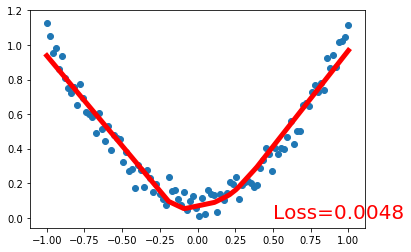

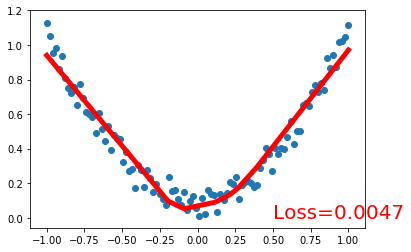

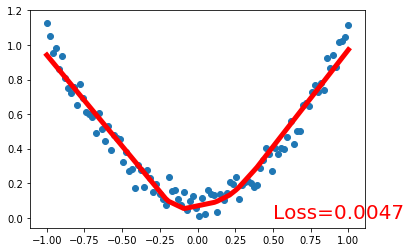

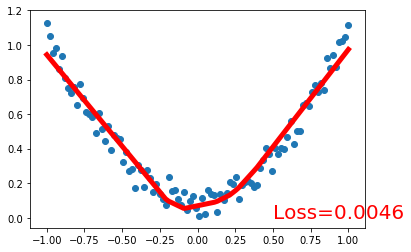

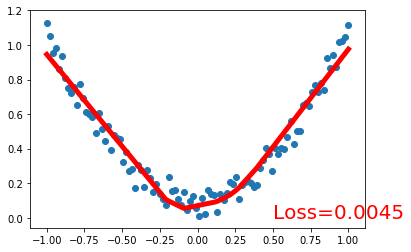

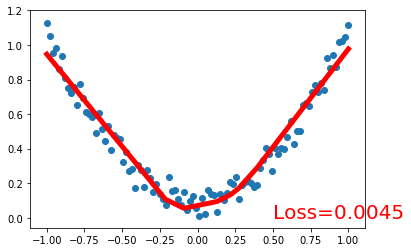

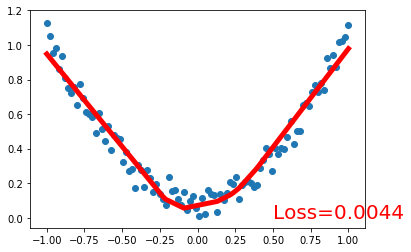

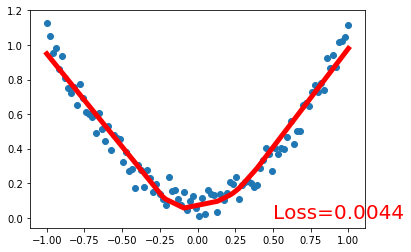

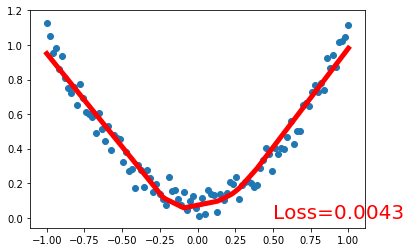

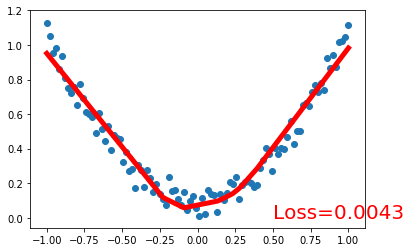

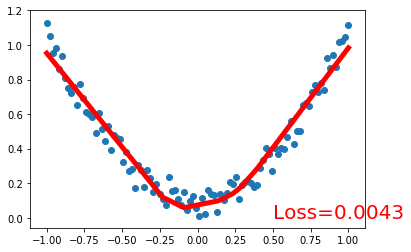

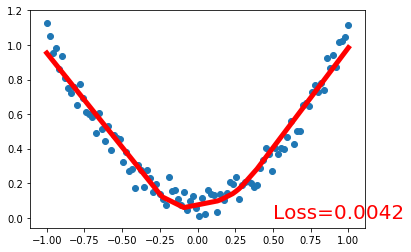

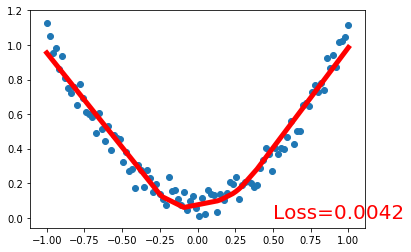

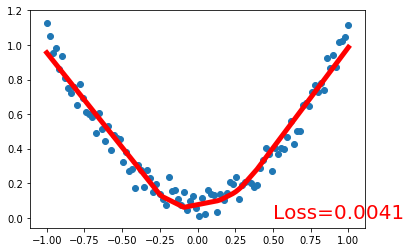

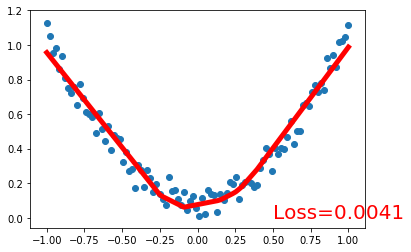

In [119]:
%matplotlib inline

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# torch can only train on Variable, so convert them to Variable
# The code below is deprecated in Pytorch 0.4. Now, autograd directly supports tensors
# x, y = Variable(x), Variable(y)

# plt.scatter(x.data.numpy(), y.data.numpy())
# plt.show()


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

net = Net(n_feature=1, n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

plt.ion()   # something about plotting

for t in range(200):
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t % 5 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

plt.ioff()
plt.show() 